In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jtiptj/chest-xray-pneumoniacovid19tuberculosis

100% 1.73G/1.74G [00:16<00:00, 73.1MB/s]
100% 1.74G/1.74G [00:16<00:00, 115MB/s] 


In [16]:
import zipfile
import os
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Replace 'your_dataset_directory.zip' with the actual zip file name
zip_file_path = '/content/chest-xray-pneumoniacovid19tuberculosis.zip'
extracted_folder_path = '/content/dataset/'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [4]:
# Define the path to the test directory
test_dir = '/content/dataset/test/'

# Use ImageDataGenerator to load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1./255)  # You can add more preprocessing options if needed

# Set batch size according to your needs
batch_size = 32

# Create a data generator for the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),  # Replace with the size you used during training
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have multiple classes
    shuffle=False  # Important: set shuffle to False to maintain the order of predictions
)

Found 771 images belonging to 4 classes.


In [6]:
num_classes = len(test_generator.class_indices)

In [7]:
# Load the individual models
resnet50_model = load_model('/content/drive/MyDrive/fine_tuned_resnet50.h5')
vgg16_model = load_model('/content/drive/MyDrive/fine_tuned_vgg16.h5')
inceptionv3_model = load_model('/content/drive/MyDrive/fine_tuned_inceptionv3.h5')

In [12]:
# Generate predictions from each model
resnet50_preds = resnet50_model.predict(test_generator)
vgg16_preds = vgg16_model.predict(test_generator)
inceptionv3_preds = inceptionv3_model.predict(test_generator)

# Combine predictions for the ensemble
ensemble_preds = np.mean([resnet50_preds, vgg16_preds, inceptionv3_preds], axis=0)

# Convert predictions to class labels
ensemble_preds_labels = np.argmax(ensemble_preds, axis=1)
y_true_labels = test_generator.classes

# Create a confusion matrix for the ensemble
conf_matrix_ensemble = confusion_matrix(y_true_labels, ensemble_preds_labels)

25/25 [==============================] - 91s 4s/step
Confusion Matrix - Ensemble Model:
[[104   1   1   0]
 [  0 193  41   0]
 [  0   6 384   0]
 [  0   0   0  41]]


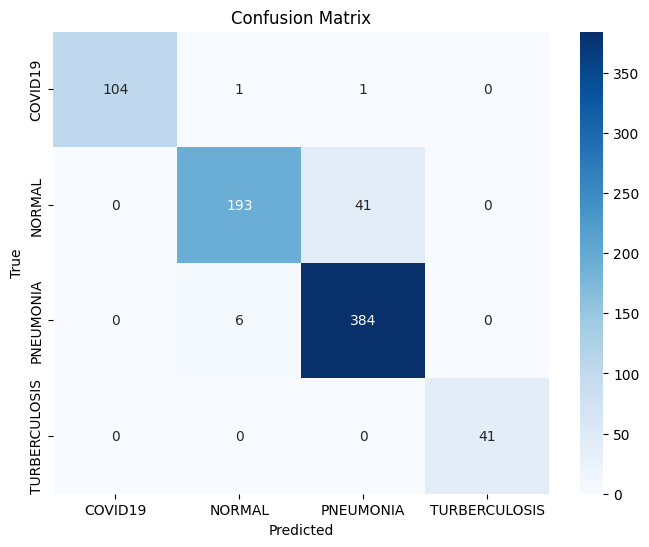


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       106
           1       0.96      0.82      0.89       234
           2       0.90      0.98      0.94       390
           3       1.00      1.00      1.00        41

    accuracy                           0.94       771
   macro avg       0.97      0.95      0.96       771
weighted avg       0.94      0.94      0.94       771



In [18]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_labels, ensemble_preds_labels))